# Spline on Spline -- Binary Response

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn.model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn import linear_model 
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statistics as stat
import pdb
import math
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
def DGP(fun_form, N, eps_noise = 1, rho = 0, corr_uniform = None, p_uniform = 0, lower = -1, upper = 1,
        corr_norm = None, p_norm = 0, mu = 0, sigma = 1/3, binary = False,seed= 100):
    np.random.seed(seed)
    p = p_uniform + p_norm
    # Generate uniform distribution
    X1 = np.empty((N,0))
    if p_uniform > 0:
        if corr_uniform is None:
            X1 = np.random.uniform(lower, upper, (N, p_uniform))
        else:
            for i in corr_uniform:
                p_corr = len(i)
                tmp = np.random.uniform(lower, upper, (N, p_corr+1))
                t = np.sqrt(rho/(1-rho))
                X1 = np.c_[X1, (tmp[:,:p_corr] + t*tmp[:,p_corr].reshape(-1,1))/(1+t)]

    # Generate log-normal
    X2 = np.empty((N,0))
    if p_norm >0:
        if corr_norm is None:
            temp = np.exp(sigma * np.random.randn(N*p_norm) + mu)
            X2 = temp.reshape(N,p_norm)
        else:
            for i in corr_norm:
                p_corr = len(i)
                tmp = np.exp(sigma*np.random.randn(N*(p_corr + 1)).reshape(N, (p_corr+1)))
                t = np.sqrt(rho / (1 - rho))
                X2 = np.c_[X2, (tmp[:,:p_corr] + t*tmp[:,p_corr].reshape(-1,1))/(1+t)]


    X = np.c_[X1,X2]
    temp = fun_form(X)
    if binary:
        p = np.exp(temp)/(1 + np.exp(temp))
        y = np.random.binomial(1, p)
        return X,y
    else:
        y = temp.reshape(-1,1) + eps_noise* np.random.randn(N,1)
        SNR = np.var(fun_form(X)) / eps_noise**2
        xname = [f'X{i}' for i in range(p)]
        X= pd.DataFrame(X,columns=xname)
        return X, y, SNR

class SplinesClassifier:
    """
    Spline on spline model for binary classification model
    """
    def __init__(self, subnet_struct, initial="MLE", fit_intercept=True):
        """
        Initialize the model object
        :param subnet_struct: specify the hidden layers structure using brackets, e.g. [k, l, m] three hidden layers
        with first layer has k nodes, second layer has l nodes and third layer has m nodes
        :param initial: initializer for weights and biases, MLE: maximum likelihood estimator is current only options
        :param fit_intercept: if True, an intercept will be included in fitting logistic regression and False otherwise
        """
        self.n_subnets = len(subnet_struct)
        self.subnet_struct = subnet_struct
        self.initial = initial
        self.fit_intercept = fit_intercept
        self.init_mod = LogisticRegression(fit_intercept=self.fit_intercept, penalty='none', solver='newton-cg')
        self.refit_mod = LogisticRegression(fit_intercept=self.fit_intercept, penalty='none', solver='newton-cg')
        self.max_iter = 100
        self.epsilon = 1e-5

        self.weight = {}
        self.bias = {}
        self.beta = {}
        self.history = {}
        self.bias_record = None
        self.beta_record = None
        self.mse_old = 0.0
        self.train_loss = []
        self.test_loss = []

        if self.n_subnets == 0:
            raise ValueError("Please specified at least one hidden layer.")

    def __init_bias(self, nodes, _yhat, _y = None):
        # tau = np.quantile(_yhat, [i / (nodes + 1) for i in range(1, (nodes +1))])
        tau = np.quantile(_yhat, [i / nodes for i in range(nodes)])
        return -tau.reshape(-1, 1)

    def __init_weight(self, J):
        return np.repeat(self.init_mod.coef_.reshape(1, -1), J, axis=0)

    def Node(self, x, W, b, beta=None):
        _b = np.repeat(b.reshape(1, -1), x.shape[0], axis=0)
        _sigma = np.maximum((np.dot(x, W.T) + _b), 0)
        if beta is None:
            return _sigma
        else:
            if len(beta) == len(b):  # check dimension
                _beta = np.repeat(beta.reshape(1, -1), x.shape[0], axis=0)
                return _beta * _sigma
            else:
                raise ValueError('Dimension of beta not match')

    def initial_values(self, _x, _y, _J):
        """
        Get initial value of bias and weight: conduct a logistic regress y on x
        :param _x: independent variable matrix
        :param _y: outcome vector
        :param _J: the number of nodes
        :return: weight initial matrix and bias initial vector
        """
        self.init_mod.fit(_x, _y)
        _mhat = np.dot(_x, np.ravel(self.init_mod.coef_)) #+ self.init_mod.intercept_
        b0 = self.__init_bias(_J, _mhat, _y)  # initial value for bias
        w0 = self.__init_weight(_J)  # initial value for weight
        return w0, b0

    def __get_Z(self, _X, _W, _bias, _beta=None):
        z1 = self.Node(_X, _W, _bias)  # Calculate hidden-layer
        z2 = z1.copy()  # Indicator for hidden layer
        z2[z2 > 0] = 1  # If the output of hiddenlayer >0 then set as 1
        n, J = z2.shape
        z3 = np.empty((n, 0))  # n * (p * J)
        for j in range(J):  # Generate the design matrix for eta node by node
            z3 = np.c_[z3, np.multiply(_X, z2[:, j].reshape(-1,1))]
        Z = np.c_[z1, z2, z3]
        if _beta is None:
            return Z
        else:
            if len(_beta) == z1.shape[1]:
                mh = np.dot(z1, _beta).reshape(-1, 1)
                return Z, mh
            else:
                raise ValueError("beta dimension not match with z1")

    def __record(self, _W, _bias, _beta, _train_mse):
        self.bias_record = np.append(self.bias_record, [_bias.flatten()], axis=0)
        self.weight_record = np.append(self.weight_record, [_W.flatten()], axis=0)
        self.beta_record = np.append(self.beta_record, [_beta.flatten()], axis=0)
        self.train_loss.append(_train_mse)

    def __test_results(self, _test_X, _test_y, _W, _bias, _beta=None):
        test_mh = self.Node(_test_X, _W, _bias, _beta)
        test_mse = roc_auc_score(_test_y , self.refit_mod.predict_proba(test_mh)[:,1])
        self.test_loss.append(test_mse)
        return test_mh


    def Logitstic(self, x, y, _wt, _bi, J, test_x=None, test_y=None):
        n,p = x.shape
        t = 0
        D = 1
        _vartheta = np.zeros(1+(p+2)*J)
        while(t < self.max_iter) & (D > self.epsilon):
            #pdb.set_trace()
            t +=1
            z = self.__get_Z(x, _wt, _bi)
            z = np.concatenate((np.ones((n,1)), z), axis = 1)
            zT = np.transpose(z)/n
            m = np.dot(z, _vartheta)
            prob = 1/(1+np.exp(-m))
            v = prob*(1-prob)
            _vartheta[(1+p):] = 0 

            de_l = np.dot(zT, (y - prob.reshape(y.shape)))
            _temp = np.multiply(v.reshape(-1, 1), z)
            dede_l = np.dot(zT, _temp)
            _delta = np.dot(np.linalg.pinv(dede_l), de_l)

            _vartheta = _vartheta + _delta.reshape(_vartheta.shape)

            _theta = _vartheta[1:]
            _beta = _theta[:J]
            _gamma = _theta[J:(2*J)]
            _eta = _theta[(2*J):]
            _eta = _eta.reshape(-1, p)
            for _i, _val in enumerate(_beta):
                if abs(_val) > 0.0001:
                    _bi[_i] += _gamma[_i]/_val
                    _wt[_i,:] += _eta[_i,:]/_val

            train_mh = self.Node(x, _wt, _bi)
            self.refit_mod.fit(train_mh, y)
            train_yhat = self.refit_mod.predict_proba(train_mh)[:,1]
            train_mse = roc_auc_score(y, train_yhat)
            _beta = self.refit_mod.coef_
            self.__record(_wt, _bi, _beta, train_mse)

            if test_x is not None:
                test_mh = self.__test_results(test_x, test_y, _wt, _bi)

            D = abs(train_mse - self.mse_old) / self.mse_old
            self.mse_old = train_mse

        if test_x is None:
            test_mh = None

        return train_mh, test_mh, _wt, _bi, _beta, t       


    def fit(self, train_X, train_y, test_X=None, test_y=None, epsilon=1e-6, learn_rate = 1, max_iter=100):
        '''
        Fit hidden layers
        :param train_X, test_X: array-like or sparse matrix, shape (n_samples, n_features) Training data
        :param train_y, test_y: array_like, shape (n_samples, 1) or (n_sample,)
         Target values. Will be cast to X's dtype if necessary
        :param epsilon: control the stop of the algorithm
        :param max_iter: The maximum number of iteration
        :return: a trained logistic model
        '''
        self.max_iter = max_iter
        self.epsilon = epsilon

        def build_subnets(layer, J, train_X_tilde, test_X_tilde=None):
            n, p = train_X_tilde.shape
            # Get initial value for weight, bias and beta
            w0, b0 = self.initial_values(train_X_tilde, train_y, J)

            train_mh = self.Node(train_X_tilde, w0, b0)
            self.refit_mod.fit(train_mh, train_y)
            self.mse_old = roc_auc_score(train_y , self.refit_mod.predict_proba(train_mh)[:,1])

            # Record beta, bias, weight and train loss
            self.weight_record= np.array([w0.flatten()])
            self.beta_record = np.array(np.zeros((1,J)))
            self.bias_record = np.array([b0.flatten()])
            self.train_loss = [self.mse_old]

            if test_X is not None: # Record test data loss
                test_mh = self.Node(test_X_tilde, w0, b0)
                test_mse_old = roc_auc_score(test_y, self.refit_mod.predict_proba(test_mh)[:,1])
                self.test_loss = [test_mse_old]

            train_mh, test_mh, _wt, _bi, _beta, n_iter = self.Logitstic(train_X_tilde, train_y, w0, b0, J,
                                                                        test_x=test_X_tilde, test_y=test_y)

            # Clean up trained layer result
            hist_key = 'subnet' + str(layer)
            best_idx = self.test_loss.index(max(self.test_loss))

            if best_idx != n_iter:
                _wt = self.weight_record[best_idx, :].reshape(J, p)
                _bi = self.bias_record[best_idx, :]
                train_mh = self.Node(train_X_tilde, _wt,_bi)
                if test_X_tilde is not None:
                    test_mh = self.Node(test_X_tilde, _wt,_bi)

                self.refit_mod.fit(train_mh, train_y)

            self.weight.update({hist_key: _wt})
            self.bias.update({hist_key: _bi})
            self.beta.update({hist_key:  self.refit_mod.coef_.flatten()})

            layer_hst = {'loss': self.train_loss, 'n_iter': n_iter, 'bias_hst': self.bias_record,
                         'weight_hst': self.weight_record, 'beta_hst': self.beta_record}

            if test_X is not None:
                layer_hst.update({'test_loss': self.test_loss})

            self.history.update({hist_key: layer_hst})
            if n_iter == self.max_iter:
                print(f"Failed to converge before max number of iteration is reached at hidden layer {layer}.")

            print(hist_key, "train AUC:", self.train_loss[best_idx])
            print(hist_key, "test AUC:", self.test_loss[best_idx])

            return train_mh, test_mh, _wt, _bi, _beta

        train_X_tilde = train_X
        test_X_tilde = test_X

        for layer, J in enumerate(self.subnet_struct):
            train_X_tilde, test_X_tilde, weight, bias, beta = build_subnets(layer, J, train_X_tilde, test_X_tilde)


    def plot_training_loss(self, plot_title = None, **kwargs):
        """
        Plot the training and testing AUC at each hidden layer
        :param plot_title: The title of the plot
        :param kwargs: params that control plt.figure()
        :return: A figure object
        """
        n_iter = []
        train_loss = []
        test_loss = []

        for k, v in self.history.items():
            n_iter.append(len(v['loss']))
            train_loss += v['loss']
            if v.get('test_loss'):
                test_loss += v['test_loss']

        iters = np.cumsum(n_iter)

        mpl.style.use('default')
        plt.figure(**kwargs)
        plt.plot(list(range(iters[-1])), train_loss, label='Train')
        if len(test_loss):
            plt.plot(list(range(iters[-1])), test_loss, label='Test')
            max_value = max(max(train_loss, test_loss))
            min_value = min(min(train_loss),min(test_loss))
        else:
            max_value = max(train_loss)
            min_value = min(train_loss)
        
        for i, v in enumerate(iters):
            cc = 'C' + str(i + 1)
            ll = 'Subnet' + str(i)
            plt.vlines((v - 1), min_value, max_value, cc, '--', label=ll)
        plt.xlabel('Number of iteration')
        plt.ylabel('AUC')
        plt.legend(loc=1)
        if plot_title is not None:
            plt.title(plot_title)
        return plt

## Use simulated data
### $y|X = Bern(p(X)), \ p(x_1,x_2) = \frac{5\beta_1 x_1}{1 + \beta_2 |x_2|}, \ x_i \sim U(-1,1), i = 1,2$ sample size n = 10000

The proportion of 1 in y: 0.4997
Failed to converge before max number of iteration is reached at hidden layer 0.
subnet0 train AUC: 0.9196859646736822
subnet0 test AUC: 0.9119776949813708
Failed to converge before max number of iteration is reached at hidden layer 1.
subnet1 train AUC: 0.9205931603384432
subnet1 test AUC: 0.9130729414118177


<module 'matplotlib.pyplot' from 'C:\\Users\\49849\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

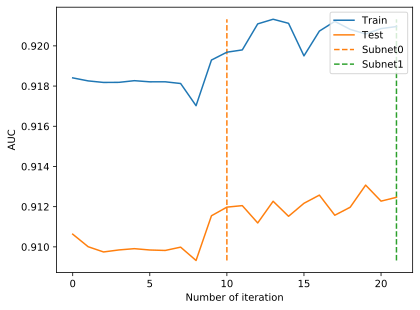

In [ ]:
def fun_form(X, beta1=-1.5, beta2=1.5):  # True objective function
    y = 5 * beta1 * X[:, 0] / (1 + beta2 * abs(X[:, 1]))
    return y

X, y = DGP(fun_form, 10000, p_uniform=2, binary = True,seed=111) # Sample size 10000
print("The proportion of 1 in y:", np.mean(y))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
SplineMod = SplinesClassifier(subnet_struct=[5,20])
SplineMod.fit(train_X, train_y, test_X=test_X, test_y=test_y, max_iter=10)
SplineMod.plot_training_loss()

## Load data
### Only extract class "0" and "1" from digits dataset for illustration 

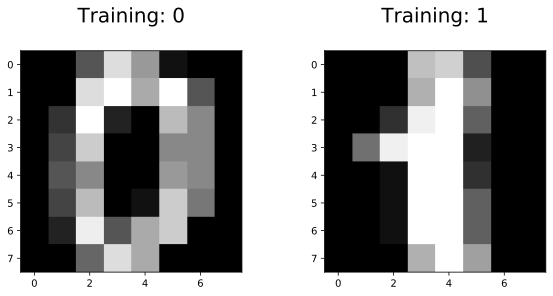

In [ ]:
digits = load_digits()
plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(digits.data[0:2], digits.target[0:2])):
    plt.subplot(1, 2, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Only extract the label is either 0 or 1 in this example
X = digits.data[(digits.target ==0)|(digits.target ==1)]
y = digits.target[(digits.target ==0)|(digits.target ==1) ]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
dataset = np.column_stack((x_train,y_train))

## Use spline on spline model to fit the dataset

subnet0 train AUC: 1.0
subnet0 test AUC: 1.0


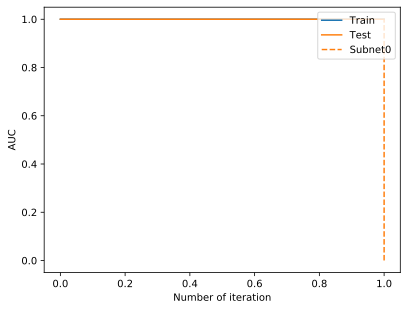

In [ ]:
SplineMod =SplinesClassifier(subnet_struct=[5]) 
# One hidden layer with 55 nodes. Iinitialized by least squares estimator
SplineMod.fit(x_train, y_train, test_X=x_test, test_y=y_test, max_iter=100)
loss_plot = SplineMod.plot_training_loss()

### Comment: the algorithm converge fast in one iteration.